# Stokeslets and Rotlets

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from itertools import product
%matplotlib inline
import seaborn as sns; sns.set(); sns.set_style("white")

In [2]:
figfile = "figs/"

We will use a single rotating rod in a fluid as an example to introduce stokeslets and rotlets. We choose to work in 3D on a grid with spacing $\Delta s = 0.1$. But first, let's start even simpler with a single point torque applied at the origin.

In [3]:
x = np.arange(-0.5, 0.5, 0.1)
y = np.arange(-0.5, 0.5, 0.1)
z = np.arange(-0.5, 0.5, 0.1)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
R = np.array([X,Y,Z])

## The Motor
Let's introduce a regularised rotlet. We need to set the regularisation parameter $\epsilon = 0.3$. This represents how thin our slender bodies are. For our numerical method to be stable we need $\epsilon^2 \approx \Delta s$.

In [4]:
e = 0.3

In [5]:
def rotlet(R,L,p,e=0.3):
    #x-x0
    R = np.array([R[i]-p[i] for i in range(3)]) 
    
    #distance squared
    r2 = np.sum(R**2,axis=0) 
    
    #scaling
    const = ((2*r2)+(5*(e**2)))/(16*np.pi*((r2+(e**2))**(5/2)))  
    
    #vector field
    U = const*np.cross(L,R,axis=0) 
    return U

We apply a torque $\tau = [0,0,0.5]$.

In [6]:
tau = np.array([0,0,0.5])

In [7]:
#torque in the z direction
U = rotlet(R,tau,p=np.array([0,0,0]))

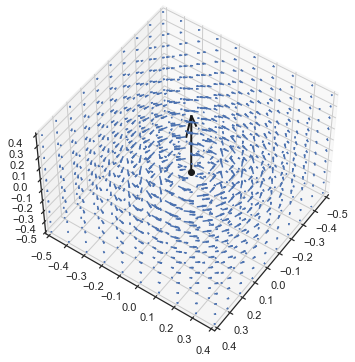

In [8]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d')

ax.plot(0,0,0,'ko')

ax.quiver(R[0], R[1], R[2], U[0], U[1], U[2],length=0.3, arrow_length_ratio=0.5)
ax.quiver(0,0,0,tau[0], tau[1], tau[2],color='k',linewidth=2)
ax.view_init(elev=50, azim=35)
ax.set_xlim([np.min(X),np.max(X)]); ax.set_ylim([np.min(Y),np.max(Y)]); ax.set_zlim([np.min(Z),np.max(Z)])
plt.savefig(figfile+"rotlet.png",dpi=300)
plt.show()

This rotation of the fluid around the $[0,0,0]$ point is expected.

## The Pusher

Let's introduce a force $f = [0.1,0,0]$ at the origin and observe how the fluid behaves. To do this we need to introduce a regularized stokeslet. 

In [9]:
def stokeslet(R,f,p,e=0.3):
    #x-x0
    R = np.array([R[i]-p[i] for i in range(3)])
    
    #distance squared
    r2 = np.sum(R**2,axis=0)
    
    #forces at each point in the grid
    F = np.array([(0*R[i])+f[i] for i in range(3)])
    
    #constants for scaling
    const_1 = ((r2)+(2*(e**2)))
    const_2 = (8*np.pi*((r2+(e**2))**(3/2)))
    
    #dot product
    dot = np.sum([f[i]*R[i] for i in range(3)],axis=0)
    
    #velocity field
    U = ((dot*R) + (F*const_1))/const_2
    return U

In [10]:
f = np.array([0.1,0,0])
Us = stokeslet(R,f,np.array([0,0,0]))

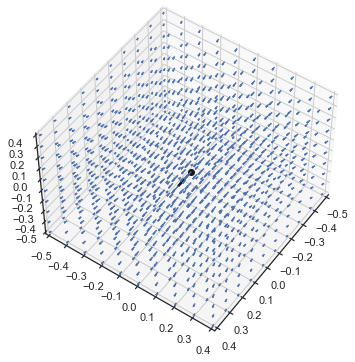

In [11]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d')

ax.view_init(elev=50, azim=35)

ax.plot(0,0,0,'ko')
ax.quiver(R[0], R[1], R[2], Us[0], Us[1], Us[2],length=2, arrow_length_ratio=0.5)

ax.quiver(0,0,0,f[0], f[1], f[2],color='k',linewidth=2)

ax.view_init(elev=50, azim=35)
ax.set_xlim([np.min(X),np.max(X)]); ax.set_ylim([np.min(Y),np.max(Y)]); ax.set_zlim([np.min(Z),np.max(Z)])
plt.savefig(figfile+"stokeslet.png",dpi=300)
plt.show()

## Combining Motor and Pusher — The Rod

We can introduce a rod placed between $[0,0,0]$ and $[0.2,0,0]$.

In [12]:
l0 = 0.2
p = np.array([[0,0,0],[l0,0,0]])

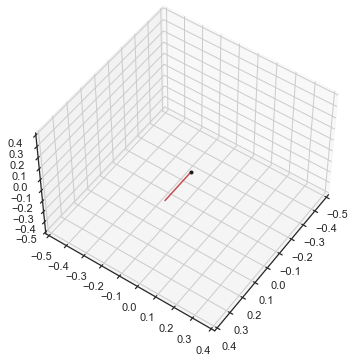

In [13]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d')

ax.plot(p.T[0],p.T[1],p.T[2],'-r');
ax.plot(0,0,0,'k.');

ax.view_init(elev=50, azim=35)
ax.set_xlim([np.min(X),np.max(X)]); ax.set_ylim([np.min(Y),np.max(Y)]); ax.set_zlim([np.min(Z),np.max(Z)])
plt.savefig(figfile+"rod.png",dpi=300)
plt.show()

When the motor rotates at $t = 0$, the rod endpoints are displaced according to the velocity of the fluid at that point. This displacement in turn generates a force on the motor. This force is approximated with Hooke's Law. If the rod is stiff it will generate a large force to maintain the distance between its endpoints.

Step 1:
Compute the velocity of the rod endpoints

In [14]:
def rod_vel(U,p,R):
    V = np.array(np.shape(U))
    V = [sp.interpolate.RegularGridInterpolator((R[0][:,0,0], R[1][0,:,0], R[2][0,0,:]), U[i]) for i in range(3)]
    Vp = np.array([V[i](p)[0] for i in range(3)])
    return Vp

In [15]:
Vp0 = rod_vel(U,p[0],R)
Vp1 = rod_vel(U,p[1],R)

Step 2: Compute the new position of the rod endpoints. Let's assume $dt = 0.01$

In [16]:
dt = 0.01

In [17]:
delP0 = (Vp0*dt)
p[0] = p[0]+delP0

delP1 = (Vp1*dt)
p[1] = p[1]+delP1

Step 3: Compute the force on the endpoint. Spring constant $\kappa$ can be assumed to be $500$.

In [18]:
k = 500

In [19]:
#force on p1 due to p0
f01 = -(k*(np.linalg.norm(p[1]-p[0])-l0)/(l0*(np.linalg.norm(p[1]-p[0]))))*(p[1]-p[0])

Add the two stokeslets and compute the flow.

In [20]:
S0 = stokeslet(R,-f01,p[0])
S1 = stokeslet(R,f01,p[1])
S = S0+S1

Net stokeslet flow:

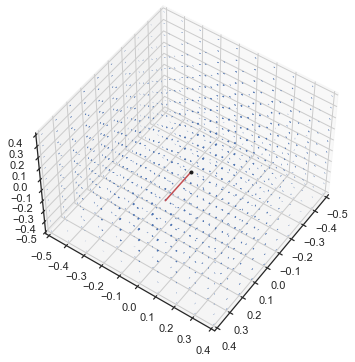

In [21]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d')

ax.plot(p.T[0],p.T[1],p.T[2],'-r');
ax.plot(p[0,0],p[0,1],p[0,2],'k.');

ax.view_init(elev=50, azim=35)

ax.quiver(R[0], R[1], R[2], S[0], S[1], S[2],length=10, arrow_length_ratio=0.5)
ax.view_init(elev=50, azim=35)
ax.set_xlim([np.min(X),np.max(X)]); ax.set_ylim([np.min(Y),np.max(Y)]); ax.set_zlim([np.min(Z),np.max(Z)])
plt.savefig(figfile+"combined_hookes.png",dpi=300)
plt.show()

Stokeslet flow due to force on motor due to endpoint:

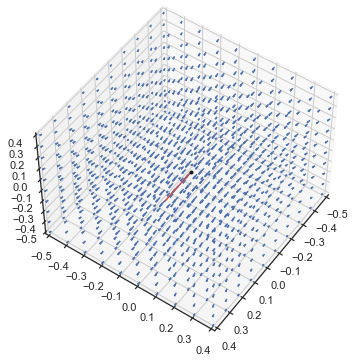

In [22]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d')

ax.plot(p.T[0],p.T[1],p.T[2],'-r');
ax.plot(p[0,0],p[0,1],p[0,2],'k.');

ax.view_init(elev=50, azim=35)

ax.quiver(R[0], R[1], R[2], S0[0], S0[1], S0[2], length=10, arrow_length_ratio=0.5)
ax.view_init(elev=50, azim=35)
ax.set_xlim([np.min(X),np.max(X)]); ax.set_ylim([np.min(Y),np.max(Y)]); ax.set_zlim([np.min(Z),np.max(Z)])
plt.savefig(figfile+"hookes_0.png",dpi=300)
plt.show()

Stokes flow on endpoint due to motor:

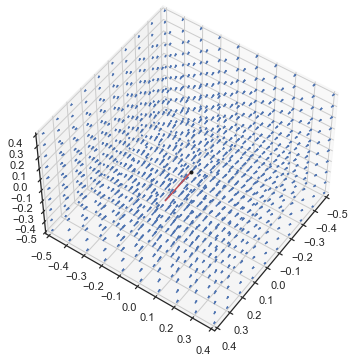

In [23]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d')

ax.plot(p.T[0],p.T[1],p.T[2],'-r');
ax.plot(p[0,0],p[0,1],p[0,1],'k.');

ax.view_init(elev=50, azim=35)

ax.quiver(R[0], R[1], R[2], S1[0], S1[1], S1[2], length=10, arrow_length_ratio=0.5)
ax.view_init(elev=50, azim=35)
ax.set_xlim([np.min(X),np.max(X)]); ax.set_ylim([np.min(Y),np.max(Y)]); ax.set_zlim([np.min(Z),np.max(Z)])
plt.savefig(figfile+"hookes_1.png",dpi=300)
plt.show()

## Evolve in Time

We can evolve the fluid flow in time and see how the rod behaves by plotting the top view over time.

In [24]:
T = 5
time = np.arange(0,T,dt)
p0_vec = np.zeros(np.shape(time))
p1_vec = np.zeros(np.shape(time))

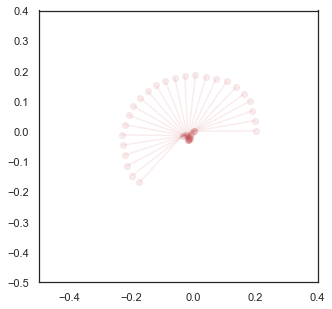

In [25]:
plt.figure(figsize=(5,5))
for i,t in enumerate(time):
    U = rotlet(R,tau,p=p[0])+S
    
    if np.mod(i,20) == 0:
        plt.plot(p.T[0],p.T[1],'ro-',alpha=0.1)

    Vp0 = rod_vel(U,p[0],R)
    Vp1 = rod_vel(U,p[1],R)
    
    delP0 = (Vp0*dt)
    p[0] = p[0]+delP0

    delP1 = (Vp1*dt)
    p[1] = p[1]+delP1
    
    f01 = (k*(np.linalg.norm(p[0]-p[1])-l0)/(l0*(np.linalg.norm(p[0]-p[1]))))*(p[0]-p[1])
    
    S0 = stokeslet(R,-f01,p[0])
    S1 = stokeslet(R,f01,p[1])
    S = S0+S1
    
plt.xlim([np.min(X),np.max(X)]); plt.ylim([np.min(Y),np.max(Y)])
plt.savefig(figfile+"rotating_rod.png",dpi=300)
plt.show()

The rod rotates in along with the direction of the fluid as expected.